In [44]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from kmodes.kmodes import KModes
from pprint import pprint

# supress warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_columns', 100)

In [45]:
!ls | grep .csv

predict.csv
training.csv


In [46]:
train_df = pd.read_csv('training.csv')
train_orig_df = train_df.copy()
pred_df = pd.read_csv('predict.csv')
train_df.head()

,id,posted_time,updated_time,age,updated_age,app_type,owner_id,owner_type,owner_influence,number_of_likes,number_of_comments,reactivity,is_mentions_me,is_mentions_connections,is_commented_by_me,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,poster_id,poster_gender,poster_is_employee,poster_is_lead,poster_is_in_connections,poster_focus,poster_order,poster_influence,participant1_id,participant1_action,participant1_gender,participant1_is_employee,participant1_is_lead,participant1_is_in_connections,participant1_focus,participant1_order,participant1_influence,participant2_id,participant2_action,participant2_gender,participant2_is_employee,participant2_is_lead,participant2_is_in_connections,participant2_focus,participant2_order,participant2_influence,participant3_id,participant3_action,participant3_gender,participant3_is_employee,participant3_is_lead,participant3_is_in_connections,participant3_focus,participant3_order,participant3_influence,participant4_id,participant4_action,participant4_gender,participant4_is_employee,participant4_is_lead,participant4_is_in_connections,participant4_focus,participant4_order,participant4_influence,participant5_id,participant5_action,participant5_gender,participant5_is_employee,participant5_is_lead,participant5_is_in_connections,participant5_focus,participant5_order,participant5_influence,rank
0,175339,1.514050e+12,1.514050e+12,6.315242e+10,6.315242e+10,other,57727,space,0.99973,1,0,1.00000,0,0,0,0,0,1,5,male,1,0,1,marketing,6,0.99962,146,liked,male,1,0,1,marketing,5,0.99899,22636,viewed,male,0,0,1,other,4,0.23077,3080,viewed,male,0,0,1,marketing,3,0.23077,44661,viewed,male,0,0,1,other,2,0.23077,3089,viewed,male,0,0,1,other,1,0.23077,0.73677
1,175348,1.514110e+12,1.515160e+12,6.309278e+10,6.204696e+10,forum,111913,space,0.99977,0,2,0.12336,0,0,0,1,0,0,146,male,1,0,1,marketing,6,0.99899,13659,commented,male,0,0,0,other,5,0.99756,146,commented,male,1,0,1,marketing,4,0.99899,22636,viewed,male,0,0,1,other,3,0.23077,3080,viewed,male,0,0,1,marketing,2,0.23077,44661,viewed,male,0,0,1,other,1,0.23077,0.78240
2,175353,1.514120e+12,1.515160e+12,6.309049e+10,6.204716e+10,forum,111913,space,0.99977,0,3,0.12336,0,0,0,1,0,0,146,male,1,0,1,marketing,6,0.99899,13659,commented,male,0,0,0,other,5,0.99756,13,commented,male,1,0,1,marketing,4,0.99895,146,commented,male,1,0,1,marketing,3,0.99899,22636,viewed,male,0,0,1,other,2,0.23077,3080,viewed,male,0,0,1,marketing,1,0.23077,0.82125
3,175371,1.514190e+12,1.514190e+12,6.301324e+10,6.301324e+10,other,9037,space,0.99949,0,0,0.00000,0,0,0,0,0,0,7,male,1,0,1,marketing,6,0.99886,22636,viewed,male,0,0,1,other,5,0.23077,3080,viewed,male,0,0,1,marketing,4,0.23077,44661,viewed,male,0,0,1,other,3,0.23077,3089,viewed,male,0,0,1,other,2,0.23077,3084,viewed,male,0,0,1,marketing,1,0.23077,0.61522
4,175372,1.514190e+12,1.514190e+12,6.301323e+10,6.301323e+10,other,9037,space,0.99949,0,0,0.00000,0,0,0,0,0,0,7,male,1,0,1,marketing,6,0.99886,22636,viewed,male,0,0,1,other,5,0.23077,3080,viewed,male,0,0,1,marketing,4,0.23077,44661,viewed,male,0,0,1,other,3,0.23077,3089,viewed,male,0,0,1,other,2,0.23077,3084,viewed,male,0,0,1,marketing,1,0.23077,0.61522


### Preprocessing

Firstly, we need to create a dataframe, consisting only of categorical data (as K-Modes only work with such info).

In [47]:
# Get rid of redundant columns
all_cols = [col for col in train_df.columns if col != 'rank']
redundant_cols = ['poster_is_employee', 'poster_is_lead', 'poster_order',
                  'participant1_is_employee', 'participant1_is_lead', 'participant1_order',
                  'participant2_is_employee', 'participant2_is_lead', 'participant2_order',
                  'participant3_is_employee', 'participant3_is_lead', 'participant3_order',
                  'participant4_is_employee', 'participant4_is_lead', 'participant4_order',
                  'participant5_is_employee', 'participant5_is_lead', 'participant5_order',
                  'id', 'participant1_id', 'participant2_id', 'participant3_id',
                  'participant4_id', 'participant5_id', 'owner_id', 'poster_id',
                  'posted_time', 'updated_time', 'age', 'updated_age']
useful_cols = [i for i in all_cols if i not in redundant_cols]

train_df = train_df[useful_cols]

In [48]:
# Categorizing useful columns
all_cols = [col for col in train_df.columns if col != 'rank']
num_cols = [col for col in all_cols if train_df[col].dtype in ['int64', 'float64']]
cat_cols = [col for col in all_cols if col not in num_cols]

print("Amount of number columns: {}".format(len(num_cols)))
print("Amount of categorical columns: {}".format(len(cat_cols)))

Amount of number columns: 22
Amount of categorical columns: 19


In [49]:
print('Looking at the categorical columns:')
for cat_col in cat_cols:
    print('\tColumn {:19} has {} unique values.'.format(cat_col, train_df[cat_col].nunique()))

Looking at the categorical columns:
	Column app_type            has 6 unique values.
	Column owner_type          has 2 unique values.
	Column poster_gender       has 2 unique values.
	Column poster_focus        has 5 unique values.
	Column participant1_action has 3 unique values.
	Column participant1_gender has 2 unique values.
	Column participant1_focus  has 4 unique values.
	Column participant2_action has 3 unique values.
	Column participant2_gender has 2 unique values.
	Column participant2_focus  has 4 unique values.
	Column participant3_action has 3 unique values.
	Column participant3_gender has 2 unique values.
	Column participant3_focus  has 4 unique values.
	Column participant4_action has 3 unique values.
	Column participant4_gender has 2 unique values.
	Column participant4_focus  has 4 unique values.
	Column participant5_action has 3 unique values.
	Column participant5_gender has 2 unique values.
	Column participant5_focus  has 4 unique values.


Lets also look, which of the numerical columns we can turn into categorical ones.

In [50]:
print('Looking at the numerical columns:')
train_df[num_cols].describe().T

Looking at the numerical columns:


,count,mean,std,min,25%,50%,75%,max
owner_influence,9418.0,0.776456,0.367675,0.10000,0.74359,0.99923,0.99977,0.99992
number_of_likes,9418.0,4.385007,6.943666,0.00000,0.00000,2.00000,6.00000,64.00000
number_of_comments,9418.0,1.650032,3.725452,0.00000,0.00000,1.00000,2.00000,145.00000
reactivity,9418.0,0.317174,0.434830,0.00000,0.00000,0.00000,1.00000,1.00000
is_mentions_me,9418.0,0.003716,0.060851,0.00000,0.00000,0.00000,0.00000,1.00000
is_mentions_connections,9418.0,0.164260,0.370531,0.00000,0.00000,0.00000,0.00000,1.00000
is_commented_by_me,9418.0,0.016245,0.126425,0.00000,0.00000,0.00000,0.00000,1.00000
is_commented_by_connections,9418.0,0.493948,0.499990,0.00000,0.00000,0.00000,1.00000,1.00000
is_liked_by_me,9418.0,0.033659,0.180359,0.00000,0.00000,0.00000,0.00000,1.00000
is_liked_by_connections,9418.0,0.651625,0.476481,0.00000,0.00000,1.00000,1.00000,1.00000


In [75]:
# Creating categorical dataframe with bins from numerical data.

cat_train_df = train_df.copy()
for col in num_cols:
    if col in ['is_mentions_me', 'is_mentions_connections', 'is_commented_by_me', 
               'is_commented_by_connections', 'is_liked_by_me', 'is_liked_by_connections',
               'participant1_is_in_connections', 'participant2_is_in_connections',
               'participant3_is_in_connections', 'participant4_is_in_connections',
               'participant5_is_in_connections']:
        cut_df = train_df.apply(lambda row: 'yes' if row[col] == 1 else 'no', axis=1)
    elif col == 'number_of_likes':
        cut_df = pd.cut(train_df[col], bins=np.arange(0, 71, 10), include_lowest=True)
    elif col == 'number_of_comments':
        cut_df = pd.cut(train_df[col], bins=np.arange(0, 151, 10), include_lowest=True)
    else:  # process all the columns, that are in [0, 1] range
        cut_df = pd.cut(train_df[col], bins=np.arange(0, 1.1, 0.1), include_lowest=True)
    
    cat_train_df[col+'_bins'] = cut_df

cat_train_df.drop(num_cols, axis=1, inplace=True)
cat_train_df.head()

,app_type,owner_type,poster_gender,poster_focus,participant1_action,participant1_gender,participant1_focus,participant2_action,participant2_gender,participant2_focus,participant3_action,participant3_gender,participant3_focus,participant4_action,participant4_gender,participant4_focus,participant5_action,participant5_gender,participant5_focus,owner_influence_bins,number_of_likes_bins,number_of_comments_bins,reactivity_bins,is_mentions_me_bins,is_mentions_connections_bins,is_commented_by_me_bins,is_commented_by_connections_bins,is_liked_by_me_bins,is_liked_by_connections_bins,poster_is_in_connections_bins,poster_influence_bins,participant1_is_in_connections_bins,participant1_influence_bins,participant2_is_in_connections_bins,participant2_influence_bins,participant3_is_in_connections_bins,participant3_influence_bins,participant4_is_in_connections_bins,participant4_influence_bins,participant5_is_in_connections_bins,participant5_influence_bins
0,other,space,male,marketing,liked,male,marketing,viewed,male,other,viewed,male,marketing,viewed,male,other,viewed,male,other,"(0.9, 1.0]","(-0.001, 10.0]","(-0.001, 10.0]","(0.9, 1.0]",no,no,no,no,no,yes,"(0.9, 1.0]","(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]"
1,forum,space,male,marketing,commented,male,other,commented,male,marketing,viewed,male,other,viewed,male,marketing,viewed,male,other,"(0.9, 1.0]","(-0.001, 10.0]","(-0.001, 10.0]","(0.1, 0.2]",no,no,no,yes,no,no,"(0.9, 1.0]","(0.9, 1.0]",no,"(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]"
2,forum,space,male,marketing,commented,male,other,commented,male,marketing,commented,male,marketing,viewed,male,other,viewed,male,marketing,"(0.9, 1.0]","(-0.001, 10.0]","(-0.001, 10.0]","(0.1, 0.2]",no,no,no,yes,no,no,"(0.9, 1.0]","(0.9, 1.0]",no,"(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]"
3,other,space,male,marketing,viewed,male,other,viewed,male,marketing,viewed,male,other,viewed,male,other,viewed,male,marketing,"(0.9, 1.0]","(-0.001, 10.0]","(-0.001, 10.0]","(-0.001, 0.1]",no,no,no,no,no,no,"(0.9, 1.0]","(0.9, 1.0]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]"
4,other,space,male,marketing,viewed,male,other,viewed,male,marketing,viewed,male,other,viewed,male,other,viewed,male,marketing,"(0.9, 1.0]","(-0.001, 10.0]","(-0.001, 10.0]","(-0.001, 0.1]",no,no,no,no,no,no,"(0.9, 1.0]","(0.9, 1.0]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]"


### KModes Clustering

In [ ]:
clusters = KModes(n_clusters=4, init='Cao', n_init=1, verbose=1).fit_predict(cat_train_df)

In [ ]:
clusters

In [ ]:
inertia = []
for num_clusters in range(1, 15):
    kmodes = KModes(n_clusters=num_clusters, init="Cao", n_init=1, verbose=0).fit(cat_train_df)
    inertia.append(kmodes.cost_)
    
# Plotting data.
plt.plot(np.arange(1, 15), inertia)

Lets take a K = 4 as a possible elbow point.

In [76]:
kmodes3_clusters = KModes(n_clusters=3, init='Cao', n_init=1, verbose=0).fit_predict(cat_train_df)
kmodes4_clusters = KModes(n_clusters=4, init='Cao', n_init=1, verbose=0).fit_predict(cat_train_df)
kmodes5_clusters = KModes(n_clusters=5, init='Cao', n_init=1, verbose=0).fit_predict(cat_train_df)
kmodes6_clusters = KModes(n_clusters=6, init='Cao', n_init=1, verbose=0).fit_predict(cat_train_df)
kmodes7_clusters = KModes(n_clusters=7, init='Cao', n_init=1, verbose=0).fit_predict(cat_train_df)
kmodes8_clusters = KModes(n_clusters=8, init='Cao', n_init=1, verbose=0).fit_predict(cat_train_df)

In [77]:
final_df = cat_train_df.copy()
final_df['kmodes3_clusters'] = kmodes3_clusters
final_df['kmodes4_clusters'] = kmodes4_clusters
final_df['kmodes5_clusters'] = kmodes5_clusters
final_df['kmodes6_clusters'] = kmodes6_clusters
final_df['kmodes7_clusters'] = kmodes7_clusters
final_df['kmodes8_clusters'] = kmodes8_clusters
final_df['rank'] = train_orig_df['rank']
final_df.head()

,app_type,owner_type,poster_gender,poster_focus,participant1_action,participant1_gender,participant1_focus,participant2_action,participant2_gender,participant2_focus,participant3_action,participant3_gender,participant3_focus,participant4_action,participant4_gender,participant4_focus,participant5_action,participant5_gender,participant5_focus,owner_influence_bins,number_of_likes_bins,number_of_comments_bins,reactivity_bins,is_mentions_me_bins,is_mentions_connections_bins,is_commented_by_me_bins,is_commented_by_connections_bins,is_liked_by_me_bins,is_liked_by_connections_bins,poster_is_in_connections_bins,poster_influence_bins,participant1_is_in_connections_bins,participant1_influence_bins,participant2_is_in_connections_bins,participant2_influence_bins,participant3_is_in_connections_bins,participant3_influence_bins,participant4_is_in_connections_bins,participant4_influence_bins,participant5_is_in_connections_bins,participant5_influence_bins,kmodes3_clusters,kmodes4_clusters,kmodes5_clusters,kmodes6_clusters,kmodes7_clusters,kmodes8_clusters,rank
0,other,space,male,marketing,liked,male,marketing,viewed,male,other,viewed,male,marketing,viewed,male,other,viewed,male,other,"(0.9, 1.0]","(-0.001, 10.0]","(-0.001, 10.0]","(0.9, 1.0]",no,no,no,no,no,yes,"(0.9, 1.0]","(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",0,0,0,0,0,0,0.73677
1,forum,space,male,marketing,commented,male,other,commented,male,marketing,viewed,male,other,viewed,male,marketing,viewed,male,other,"(0.9, 1.0]","(-0.001, 10.0]","(-0.001, 10.0]","(0.1, 0.2]",no,no,no,yes,no,no,"(0.9, 1.0]","(0.9, 1.0]",no,"(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",0,0,0,5,2,2,0.78240
2,forum,space,male,marketing,commented,male,other,commented,male,marketing,commented,male,marketing,viewed,male,other,viewed,male,marketing,"(0.9, 1.0]","(-0.001, 10.0]","(-0.001, 10.0]","(0.1, 0.2]",no,no,no,yes,no,no,"(0.9, 1.0]","(0.9, 1.0]",no,"(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",0,0,0,5,2,2,0.82125
3,other,space,male,marketing,viewed,male,other,viewed,male,marketing,viewed,male,other,viewed,male,other,viewed,male,marketing,"(0.9, 1.0]","(-0.001, 10.0]","(-0.001, 10.0]","(-0.001, 0.1]",no,no,no,no,no,no,"(0.9, 1.0]","(0.9, 1.0]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",0,3,3,3,3,3,0.61522
4,other,space,male,marketing,viewed,male,other,viewed,male,marketing,viewed,male,other,viewed,male,other,viewed,male,marketing,"(0.9, 1.0]","(-0.001, 10.0]","(-0.001, 10.0]","(-0.001, 0.1]",no,no,no,no,no,no,"(0.9, 1.0]","(0.9, 1.0]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",0,3,3,3,3,3,0.61522


### Visualizing Results

In [78]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import animation
import plotly.express as px
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [79]:
def prepare_tsne(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components, random_state=1).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['kmodes3_clusters'] = kmeans_labels
    
    return df_matrix

def plot_animation(df, label_column, name):
    def update(num):
        ax.view_init(200, num)

    colors = plt.get_cmap('tab10').colors
    colors = plt.get_cmap('Set3').colors
    N = 360
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for label in tsne_3d_df[label_column].unique():
        label_df = tsne_3d_df[tsne_3d_df[label_column] == label]
        sc = ax.scatter(label_df['x'], label_df['y'], label_df['z'], c=np.array(colors[label]).reshape(1, -1),
               label=f"Cluster {label}", s=6, depthshade=True)
  
    ax.legend(loc='upper right')
    ax.set_zlim(-15, 25)
    ax.set_xlim(-20, 20)
    plt.tight_layout()
    ani = animation.FuncAnimation(fig, update, N, blit=False, interval=50)
    ani.save('kmodes_results/{}.gif'.format(name), writer='imagemagick')
    plt.show()

Doing one-hot encoding, so we can interpret data well enough.

In [80]:
# Creating dataframe for future visualization.

encoder = OneHotEncoder(handle_unknown='ignore')

encoder.fit(train_df[cat_cols].to_numpy())
rez = encoder.transform(train_df[cat_cols].to_numpy())
rez_df = pd.DataFrame(rez.toarray())
    
rez_df.index = train_df.index

new_feature_names = encoder.get_feature_names(cat_cols)
rename_to_new = {old: new for old, new in zip(list(range(len(new_feature_names))), new_feature_names)}
rez_df = rez_df.rename(rename_to_new, axis=1)

final_enc_df = train_df.copy()
final_enc_df = final_enc_df.merge(rez_df, right_index=True, left_index=True, how='outer')
final_enc_df = final_enc_df.drop(cat_cols, axis=1)

In [81]:
# Adding results of clustering to dataframe.

final_enc_df['kmodes3_clusters'] = kmodes3_clusters
final_enc_df['kmodes4_clusters'] = kmodes4_clusters
final_enc_df['kmodes5_clusters'] = kmodes5_clusters
final_enc_df['kmodes6_clusters'] = kmodes6_clusters
final_enc_df['kmodes7_clusters'] = kmodes7_clusters
final_enc_df['kmodes8_clusters'] = kmodes8_clusters
final_enc_df['rank'] = train_orig_df['rank']

In [89]:
# Creating dataframe for t-SNE visualization

tsne_3d_df = prepare_tsne(3, final_enc_df, kmodes3_clusters)
tsne_3d_df['kmodes4_clusters'] = kmodes4_clusters
tsne_3d_df['kmodes5_clusters'] = kmodes5_clusters
tsne_3d_df['kmodes6_clusters'] = kmodes6_clusters
tsne_3d_df['kmodes7_clusters'] = kmodes7_clusters
tsne_3d_df['kmodes8_clusters'] = kmodes8_clusters

tsne_3d_df.head()

,x,y,z,kmodes3_clusters,kmodes4_clusters,kmodes5_clusters,kmodes6_clusters,kmodes7_clusters,kmodes8_clusters
0,-8.445583,-9.496431,18.815060,0,0,0,0,0,0
1,-19.189100,5.519873,-15.687512,0,0,0,5,2,2
2,-20.681042,-12.782639,6.717944,0,0,0,5,2,2
3,-10.471403,26.304060,-10.000550,0,3,3,3,3,3
4,-10.511415,26.145782,-9.397012,0,3,3,3,3,3


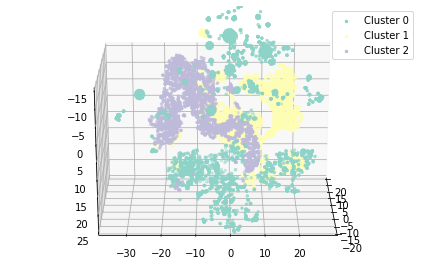

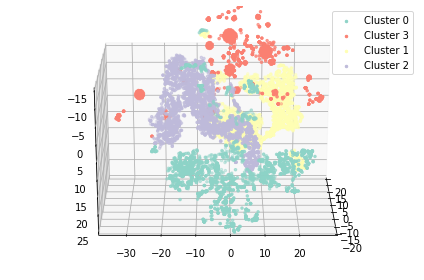

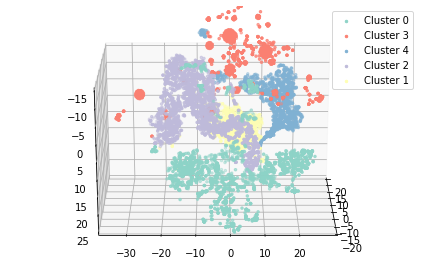

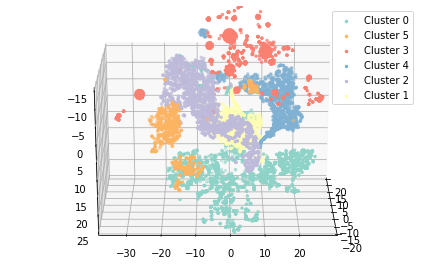

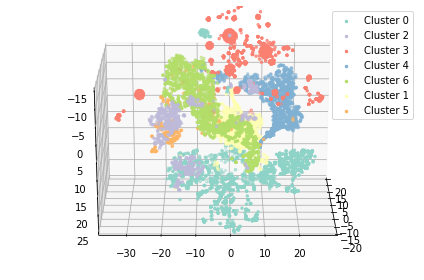

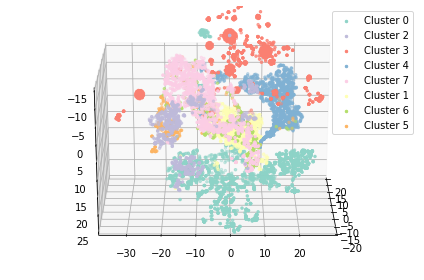

In [90]:
plot_animation(tsne_3d_df, 'kmodes3_clusters', 'kmodes3')
plot_animation(tsne_3d_df, 'kmodes4_clusters', 'kmodes4')
plot_animation(tsne_3d_df, 'kmodes5_clusters', 'kmodes5')
plot_animation(tsne_3d_df, 'kmodes6_clusters', 'kmodes6')
plot_animation(tsne_3d_df, 'kmodes7_clusters', 'kmodes7')
plot_animation(tsne_3d_df, 'kmodes8_clusters', 'kmodes8')

### Interpreting Results

In [82]:
from sklearn.preprocessing import MinMaxScaler

#### Using pandas.DataFrame.describe()

In [87]:
cluster_name = 'kmodes8_clusters'
drop_columns = ['kmodes{}_clusters'.format(i) for i in range(3, 9)] + ['rank']

summary_clusters = []
for i in range(np.max(final_df[cluster_name]) + 1):
    print("Cluster {}:".format(i))
    summary = final_df[final_df[cluster_name] == i].drop(drop_columns, axis=1).describe(include='all').T
    summary['% of top'] = summary.apply(lambda row: '{:.3f}'.format(row['freq'] * 100 / row['count']), axis=1)
    summary_clusters.append(summary)
    display(summary.T)

Cluster 0:


,app_type,owner_type,poster_gender,poster_focus,participant1_action,participant1_gender,participant1_focus,participant2_action,participant2_gender,participant2_focus,participant3_action,participant3_gender,participant3_focus,participant4_action,participant4_gender,participant4_focus,participant5_action,participant5_gender,participant5_focus,owner_influence_bins,number_of_likes_bins,number_of_comments_bins,reactivity_bins,is_mentions_me_bins,is_mentions_connections_bins,is_commented_by_me_bins,is_commented_by_connections_bins,is_liked_by_me_bins,is_liked_by_connections_bins,poster_is_in_connections_bins,poster_influence_bins,participant1_is_in_connections_bins,participant1_influence_bins,participant2_is_in_connections_bins,participant2_influence_bins,participant3_is_in_connections_bins,participant3_influence_bins,participant4_is_in_connections_bins,participant4_influence_bins,participant5_is_in_connections_bins,participant5_influence_bins
count,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444,2444
unique,6,2,2,5,2,2,4,3,2,4,3,2,4,2,2,3,1,1,2,6,1,1,6,2,2,2,2,2,2,2,9,2,5,2,8,2,6,2,4,1,1
top,other,space,male,marketing,liked,male,marketing,viewed,male,other,viewed,male,marketing,viewed,male,other,viewed,male,other,"(0.9, 1.0]","(-0.001, 10.0]","(-0.001, 10.0]","(-0.001, 0.1]",no,no,no,no,no,yes,"(0.9, 1.0]","(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]"
freq,1861,2119,2029,1756,1343,2012,1822,1195,2194,1464,2004,2357,1520,2435,2442,1633,2444,2444,2013,1750,2444,2444,1383,2441,2322,2425,1579,2407,1668,1788,2377,1961,2398,2168,1215,2352,2007,2441,2435,2444,2444
% of top,76.146,86.702,83.020,71.849,54.951,82.324,74.550,48.895,89.771,59.902,81.997,96.440,62.193,99.632,99.918,66.817,100.000,100.000,82.365,71.604,100.000,100.000,56.588,99.877,95.008,99.223,64.607,98.486,68.249,73.159,97.259,80.237,98.118,88.707,49.714,96.236,82.119,99.877,99.632,100.000,100.000


Cluster 1:


,app_type,owner_type,poster_gender,poster_focus,participant1_action,participant1_gender,participant1_focus,participant2_action,participant2_gender,participant2_focus,participant3_action,participant3_gender,participant3_focus,participant4_action,participant4_gender,participant4_focus,participant5_action,participant5_gender,participant5_focus,owner_influence_bins,number_of_likes_bins,number_of_comments_bins,reactivity_bins,is_mentions_me_bins,is_mentions_connections_bins,is_commented_by_me_bins,is_commented_by_connections_bins,is_liked_by_me_bins,is_liked_by_connections_bins,poster_is_in_connections_bins,poster_influence_bins,participant1_is_in_connections_bins,participant1_influence_bins,participant2_is_in_connections_bins,participant2_influence_bins,participant3_is_in_connections_bins,participant3_influence_bins,participant4_is_in_connections_bins,participant4_influence_bins,participant5_is_in_connections_bins,participant5_influence_bins
count,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224,1224
unique,5,2,2,4,2,2,4,2,2,4,3,2,4,3,2,4,3,2,4,6,4,2,6,1,2,2,2,2,2,2,5,2,5,2,4,2,5,2,5,2,6
top,other,user,male,marketing,commented,male,marketing,liked,male,marketing,liked,male,marketing,liked,male,marketing,liked,male,other,"(-0.001, 0.1]","(-0.001, 10.0]","(-0.001, 10.0]","(-0.001, 0.1]",no,no,no,yes,no,yes,"(0.9, 1.0]","(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.9, 1.0]"
freq,1176,842,912,843,983,875,900,788,882,858,1124,868,836,1150,876,817,924,913,597,712,935,1223,1076,1224,1149,1221,843,1212,1218,958,1208,969,1218,920,1216,885,1201,874,1153,929,915
% of top,96.078,68.791,74.510,68.873,80.310,71.487,73.529,64.379,72.059,70.098,91.830,70.915,68.301,93.954,71.569,66.748,75.490,74.592,48.775,58.170,76.389,99.918,87.908,100.000,93.873,99.755,68.873,99.020,99.510,78.268,98.693,79.167,99.510,75.163,99.346,72.304,98.121,71.405,94.199,75.899,74.755


Cluster 2:


,app_type,owner_type,poster_gender,poster_focus,participant1_action,participant1_gender,participant1_focus,participant2_action,participant2_gender,participant2_focus,participant3_action,participant3_gender,participant3_focus,participant4_action,participant4_gender,participant4_focus,participant5_action,participant5_gender,participant5_focus,owner_influence_bins,number_of_likes_bins,number_of_comments_bins,reactivity_bins,is_mentions_me_bins,is_mentions_connections_bins,is_commented_by_me_bins,is_commented_by_connections_bins,is_liked_by_me_bins,is_liked_by_connections_bins,poster_is_in_connections_bins,poster_influence_bins,participant1_is_in_connections_bins,participant1_influence_bins,participant2_is_in_connections_bins,participant2_influence_bins,participant3_is_in_connections_bins,participant3_influence_bins,participant4_is_in_connections_bins,participant4_influence_bins,participant5_is_in_connections_bins,participant5_influence_bins
count,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862,862
unique,4,2,2,5,1,2,4,2,2,4,3,2,4,3,2,4,3,2,4,5,3,3,6,2,2,2,2,2,2,2,7,2,4,2,4,2,6,2,6,2,3
top,forum,space,male,marketing,commented,male,other,commented,male,marketing,commented,male,marketing,commented,male,marketing,viewed,male,other,"(0.9, 1.0]","(-0.001, 10.0]","(-0.001, 10.0]","(-0.001, 0.1]",no,no,no,yes,no,no,"(0.9, 1.0]","(0.9, 1.0]",no,"(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.2, 0.3]"
freq,685,857,783,651,862,831,663,856,740,524,686,754,499,384,810,508,689,824,534,731,860,859,473,856,663,836,788,859,647,661,778,694,847,653,837,676,692,719,492,814,689
% of top,79.466,99.420,90.835,75.522,100.000,96.404,76.914,99.304,85.847,60.789,79.582,87.471,57.889,44.548,93.968,58.933,79.930,95.592,61.949,84.803,99.768,99.652,54.872,99.304,76.914,96.984,91.415,99.652,75.058,76.682,90.255,80.510,98.260,75.754,97.100,78.422,80.278,83.411,57.077,94.432,79.930


Cluster 3:


,app_type,owner_type,poster_gender,poster_focus,participant1_action,participant1_gender,participant1_focus,participant2_action,participant2_gender,participant2_focus,participant3_action,participant3_gender,participant3_focus,participant4_action,participant4_gender,participant4_focus,participant5_action,participant5_gender,participant5_focus,owner_influence_bins,number_of_likes_bins,number_of_comments_bins,reactivity_bins,is_mentions_me_bins,is_mentions_connections_bins,is_commented_by_me_bins,is_commented_by_connections_bins,is_liked_by_me_bins,is_liked_by_connections_bins,poster_is_in_connections_bins,poster_influence_bins,participant1_is_in_connections_bins,participant1_influence_bins,participant2_is_in_connections_bins,participant2_influence_bins,participant3_is_in_connections_bins,participant3_influence_bins,participant4_is_in_connections_bins,participant4_influence_bins,participant5_is_in_connections_bins,participant5_influence_bins
count,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643,1643
unique,6,2,2,5,2,1,4,3,2,2,3,1,2,1,1,2,1,1,2,6,1,1,4,1,1,2,2,1,2,2,9,2,3,2,3,2,3,1,1,1,1
top,other,space,male,marketing,viewed,male,other,viewed,male,marketing,viewed,male,other,viewed,male,other,viewed,male,marketing,"(0.9, 1.0]","(-0.001, 10.0]","(-0.001, 10.0]","(-0.001, 0.1]",no,no,no,no,no,no,"(0.9, 1.0]","(0.9, 1.0]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]",yes,"(0.2, 0.3]"
freq,1030,1409,1461,1066,1632,1643,1640,1634,1642,1640,1640,1643,1641,1643,1643,1637,1643,1643,1635,1049,1643,1643,1626,1643,1643,1642,1637,1643,1641,1200,1452,1638,1636,1639,1634,1641,1640,1643,1643,1643,1643
% of top,62.690,85.758,88.923,64.881,99.330,100.000,99.817,99.452,99.939,99.817,99.817,100.000,99.878,100.000,100.000,99.635,100.000,100.000,99.513,63.847,100.000,100.000,98.965,100.000,100.000,99.939,99.635,100.000,99.878,73.037,88.375,99.696,99.574,99.757,99.452,99.878,99.817,100.000,100.000,100.000,100.000


Cluster 4:


,app_type,owner_type,poster_gender,poster_focus,participant1_action,participant1_gender,participant1_focus,participant2_action,participant2_gender,participant2_focus,participant3_action,participant3_gender,participant3_focus,participant4_action,participant4_gender,participant4_focus,participant5_action,participant5_gender,participant5_focus,owner_influence_bins,number_of_likes_bins,number_of_comments_bins,reactivity_bins,is_mentions_me_bins,is_mentions_connections_bins,is_commented_by_me_bins,is_commented_by_connections_bins,is_liked_by_me_bins,is_liked_by_connections_bins,poster_is_in_connections_bins,poster_influence_bins,participant1_is_in_connections_bins,participant1_influence_bins,participant2_is_in_connections_bins,participant2_influence_bins,participant3_is_in_connections_bins,participant3_influence_bins,participant4_is_in_connections_bins,participant4_influence_bins,participant5_is_in_connections_bins,participant5_influence_bins
count,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385,1385
unique,5,2,2,4,2,2,4,2,2,4,2,2,4,2,2,4,2,2,4,6,5,1,6,2,2,2,2,2,2,2,4,2,5,2,7,2,8,2,6,2,8
top,other,space,male,marketing,liked,male,marketing,liked,male,marketing,liked,male,marketing,liked,male,marketing,liked,male,marketing,"(0.9, 1.0]","(-0.001, 10.0]","(-0.001, 10.0]","(0.9, 1.0]",no,no,no,no,no,yes,"(0.9, 1.0]","(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.9, 1.0]"
freq,1333,1165,1040,1099,934,1177,1050,1175,1139,1051,1335,1146,1068,1275,1133,981,1121,1094,1013,1253,1060,1385,775,1382,1338,1363,1031,1271,1383,1060,1360,1041,1348,1055,1362,1078,1372,1082,1251,1120,1103
% of top,96.245,84.116,75.090,79.350,67.437,84.982,75.812,84.838,82.238,75.884,96.390,82.744,77.112,92.058,81.805,70.830,80.939,78.989,73.141,90.469,76.534,100.000,55.957,99.783,96.606,98.412,74.440,91.769,99.856,76.534,98.195,75.162,97.329,76.173,98.339,77.834,99.061,78.123,90.325,80.866,79.639


Cluster 5:


,app_type,owner_type,poster_gender,poster_focus,participant1_action,participant1_gender,participant1_focus,participant2_action,participant2_gender,participant2_focus,participant3_action,participant3_gender,participant3_focus,participant4_action,participant4_gender,participant4_focus,participant5_action,participant5_gender,participant5_focus,owner_influence_bins,number_of_likes_bins,number_of_comments_bins,reactivity_bins,is_mentions_me_bins,is_mentions_connections_bins,is_commented_by_me_bins,is_commented_by_connections_bins,is_liked_by_me_bins,is_liked_by_connections_bins,poster_is_in_connections_bins,poster_influence_bins,participant1_is_in_connections_bins,participant1_influence_bins,participant2_is_in_connections_bins,participant2_influence_bins,participant3_is_in_connections_bins,participant3_influence_bins,participant4_is_in_connections_bins,participant4_influence_bins,participant5_is_in_connections_bins,participant5_influence_bins
count,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282,282
unique,4,2,2,5,1,2,4,2,2,4,2,2,4,3,2,4,3,2,4,4,4,2,6,2,2,2,2,2,2,2,5,2,5,2,5,2,4,2,7,2,5
top,forum,space,male,marketing,commented,male,other,commented,male,marketing,commented,male,marketing,commented,male,other,liked,male,marketing,"(0.9, 1.0]","(-0.001, 10.0]","(-0.001, 10.0]","(-0.001, 0.1]",no,no,no,yes,no,yes,"(-0.001, 0.1]","(0.9, 1.0]",no,"(0.9, 1.0]",no,"(0.9, 1.0]",no,"(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.9, 1.0]"
freq,219,274,237,209,282,264,224,280,231,177,249,233,187,178,230,145,142,249,239,234,265,281,194,277,235,267,238,276,227,170,239,245,274,165,257,149,250,198,229,241,239
% of top,77.660,97.163,84.043,74.113,100.000,93.617,79.433,99.291,81.915,62.766,88.298,82.624,66.312,63.121,81.560,51.418,50.355,88.298,84.752,82.979,93.972,99.645,68.794,98.227,83.333,94.681,84.397,97.872,80.496,60.284,84.752,86.879,97.163,58.511,91.135,52.837,88.652,70.213,81.206,85.461,84.752


Cluster 6:


,app_type,owner_type,poster_gender,poster_focus,participant1_action,participant1_gender,participant1_focus,participant2_action,participant2_gender,participant2_focus,participant3_action,participant3_gender,participant3_focus,participant4_action,participant4_gender,participant4_focus,participant5_action,participant5_gender,participant5_focus,owner_influence_bins,number_of_likes_bins,number_of_comments_bins,reactivity_bins,is_mentions_me_bins,is_mentions_connections_bins,is_commented_by_me_bins,is_commented_by_connections_bins,is_liked_by_me_bins,is_liked_by_connections_bins,poster_is_in_connections_bins,poster_influence_bins,participant1_is_in_connections_bins,participant1_influence_bins,participant2_is_in_connections_bins,participant2_influence_bins,participant3_is_in_connections_bins,participant3_influence_bins,participant4_is_in_connections_bins,participant4_influence_bins,participant5_is_in_connections_bins,participant5_influence_bins
count,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289
unique,4,2,2,4,1,2,4,2,2,4,2,2,4,3,2,4,3,2,4,2,7,3,6,2,2,2,1,2,2,2,3,2,2,2,3,2,1,2,2,2,5
top,other,space,female,marketing,commented,male,marketing,commented,male,marketing,commented,female,marketing,commented,female,marketing,commented,male,marketing,"(0.9, 1.0]","(-0.001, 10.0]","(-0.001, 10.0]","(0.9, 1.0]",no,no,no,yes,no,yes,"(0.9, 1.0]","(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.9, 1.0]"
freq,276,251,189,233,289,210,234,286,208,240,253,160,240,200,165,211,158,223,238,275,97,240,155,288,230,280,289,243,284,209,284,235,288,242,285,229,289,215,279,223,266
% of top,95.502,86.851,65.398,80.623,100.000,72.664,80.969,98.962,71.972,83.045,87.543,55.363,83.045,69.204,57.093,73.010,54.671,77.163,82.353,95.156,33.564,83.045,53.633,99.654,79.585,96.886,100.000,84.083,98.270,72.318,98.270,81.315,99.654,83.737,98.616,79.239,100.000,74.394,96.540,77.163,92.042


Cluster 7:


,app_type,owner_type,poster_gender,poster_focus,participant1_action,participant1_gender,participant1_focus,participant2_action,participant2_gender,participant2_focus,participant3_action,participant3_gender,participant3_focus,participant4_action,participant4_gender,participant4_focus,participant5_action,participant5_gender,participant5_focus,owner_influence_bins,number_of_likes_bins,number_of_comments_bins,reactivity_bins,is_mentions_me_bins,is_mentions_connections_bins,is_commented_by_me_bins,is_commented_by_connections_bins,is_liked_by_me_bins,is_liked_by_connections_bins,poster_is_in_connections_bins,poster_influence_bins,participant1_is_in_connections_bins,participant1_influence_bins,participant2_is_in_connections_bins,participant2_influence_bins,participant3_is_in_connections_bins,participant3_influence_bins,participant4_is_in_connections_bins,participant4_influence_bins,participant5_is_in_connections_bins,participant5_influence_bins
count,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289,1289
unique,4,2,2,5,1,2,4,1,2,4,2,2,4,3,2,4,3,2,4,6,7,9,6,2,2,2,2,2,2,2,7,2,4,2,5,2,5,2,5,2,6
top,other,space,male,marketing,commented,male,marketing,commented,male,marketing,commented,male,marketing,commented,male,marketing,commented,male,marketing,"(0.9, 1.0]","(-0.001, 10.0]","(-0.001, 10.0]","(-0.001, 0.1]",no,yes,no,yes,no,yes,"(0.9, 1.0]","(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.9, 1.0]",yes,"(0.9, 1.0]"
freq,1177,1244,1145,1079,1289,1122,1086,1289,1151,1051,1215,1193,1024,898,1188,918,655,1115,1001,1108,964,1222,531,1272,998,1231,1269,1190,1140,1060,1263,1086,1278,1096,1267,1078,1270,1062,1143,1063,1066
% of top,91.311,96.509,88.829,83.708,100.000,87.044,84.251,100.000,89.294,81.536,94.259,92.552,79.441,69.666,92.164,71.218,50.815,86.501,77.657,85.958,74.787,94.802,41.195,98.681,77.424,95.500,98.448,92.320,88.441,82.234,97.983,84.251,99.147,85.027,98.293,83.631,98.526,82.389,88.673,82.467,82.700


In [84]:
# Trying to automize searching for differences

def show_difference(summary_clusters):
    n = len(summary_clusters)
    for i in range(n):
        for j in range(i+1, n):
            print("Difference between {} and {} clusters:".format(i, j))
            one = summary_clusters[i]
            other = summary_clusters[j]
            for k in range(one.shape[0]):
                mode_one = one.iloc[k]['top']
                mode_other = other.iloc[k]['top']
                if mode_one != mode_other:
                    print("\t{:36s} {} - {}".format(one.iloc[k].name + ":", mode_one, mode_other))

In [88]:
show_difference(summary_clusters=summary_clusters)

Difference between 0 and 1 clusters:
	owner_type:                          space - user
	participant1_action:                 liked - commented
	participant2_action:                 viewed - liked
	participant2_focus:                  other - marketing
	participant3_action:                 viewed - liked
	participant4_action:                 viewed - liked
	participant4_focus:                  other - marketing
	participant5_action:                 viewed - liked
	owner_influence_bins:                (0.9, 1.0] - (-0.001, 0.1]
	is_commented_by_connections_bins:    no - yes
	participant3_influence_bins:         (0.2, 0.3] - (0.9, 1.0]
	participant4_influence_bins:         (0.2, 0.3] - (0.9, 1.0]
	participant5_influence_bins:         (0.2, 0.3] - (0.9, 1.0]
Difference between 0 and 2 clusters:
	app_type:                            other - forum
	participant1_action:                 liked - commented
	participant1_focus:                  marketing - other
	participant2_action:            

	participant1_focus:                  other - marketing
	participant5_action:                 viewed - commented
	participant5_focus:                  other - marketing
	is_mentions_connections_bins:        no - yes
	is_liked_by_connections_bins:        no - yes
	participant1_is_in_connections_bins: no - yes
	participant5_influence_bins:         (0.2, 0.3] - (0.9, 1.0]
Difference between 3 and 4 clusters:
	participant1_action:                 viewed - liked
	participant1_focus:                  other - marketing
	participant2_action:                 viewed - liked
	participant3_action:                 viewed - liked
	participant3_focus:                  other - marketing
	participant4_action:                 viewed - liked
	participant4_focus:                  other - marketing
	participant5_action:                 viewed - liked
	reactivity_bins:                     (-0.001, 0.1] - (0.9, 1.0]
	is_liked_by_connections_bins:        no - yes
	participant1_influence_bins:         (0.2, 0.

#### K-Modes (k=3)

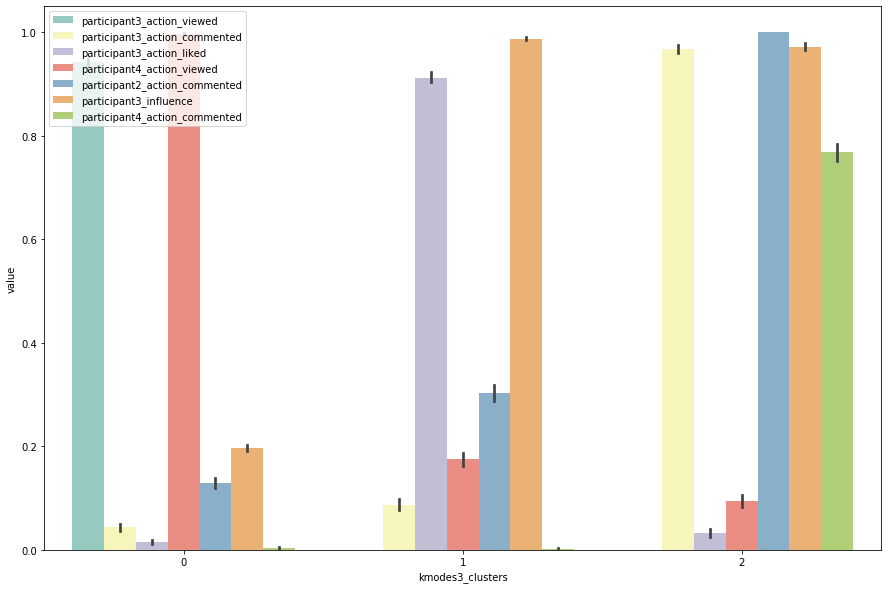

In [67]:
scaler = MinMaxScaler()
df = final_enc_df.drop(drop_columns, axis=1)
scaled_df = pd.DataFrame(scaler.fit_transform(df))
scaled_df.columns = df.columns
scaled_df['kmodes3_clusters'] = kmodes3_clusters

df_mean = scaled_df.groupby('kmodes3_clusters').mean().reset_index()

results = pd.DataFrame(columns=['var', 'std'])
for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]
selected_columns = list(results.sort_values('std', ascending=False).head(7)['var'].values) + ['kmodes3_clusters']

# Plot data.
tidy = scaled_df[selected_columns].melt(id_vars='kmodes3_clusters')
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x='kmodes3_clusters', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper left')
plt.savefig("kmodes_results/kmodes3_results.jpg", dpi=300)

#### K-Modes (k=4)

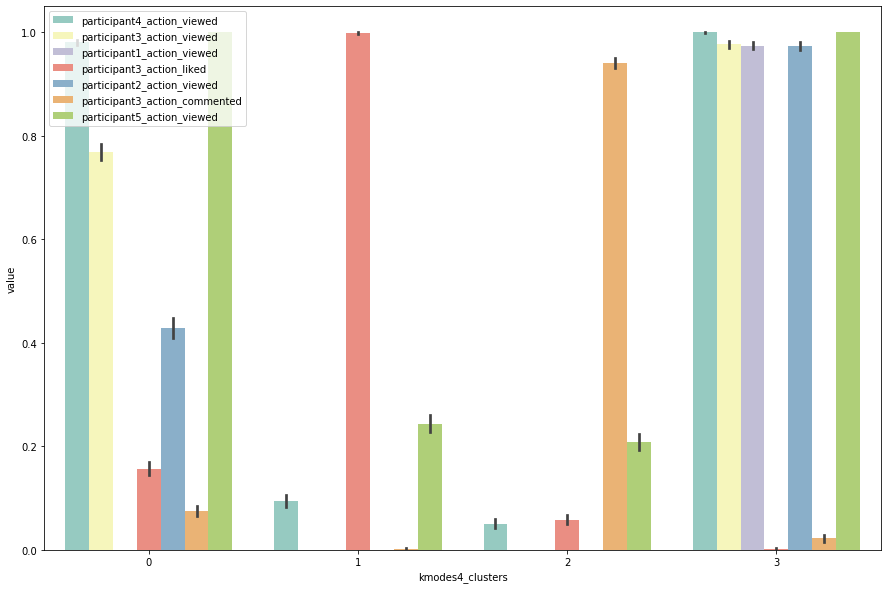

In [68]:
scaler = MinMaxScaler()
df = final_enc_df.drop(drop_columns, axis=1)
scaled_df = pd.DataFrame(scaler.fit_transform(df))
scaled_df.columns = df.columns
scaled_df['kmodes4_clusters'] = kmodes4_clusters

df_mean = scaled_df.groupby('kmodes4_clusters').mean().reset_index()

results = pd.DataFrame(columns=['var', 'std'])
for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]
selected_columns = list(results.sort_values('std', ascending=False).head(7)['var'].values) + ['kmodes4_clusters']

# Plot data.
tidy = scaled_df[selected_columns].melt(id_vars='kmodes4_clusters')
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x='kmodes4_clusters', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper left')
plt.savefig("kmodes_results/kmodes4_results.jpg", dpi=300)

#### K-Modes (k=5)

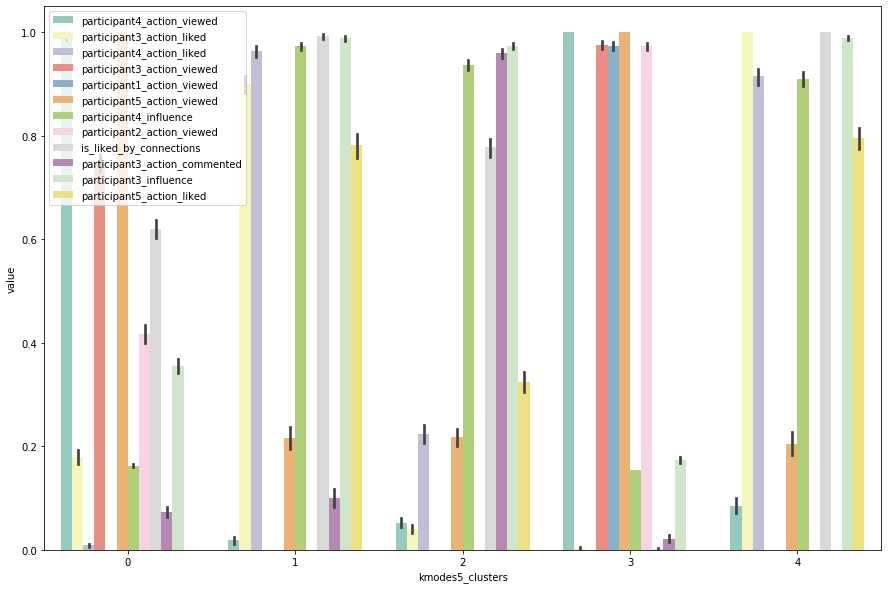

In [69]:
scaler = MinMaxScaler()
df = final_enc_df.drop(drop_columns, axis=1)
scaled_df = pd.DataFrame(scaler.fit_transform(df))
scaled_df.columns = df.columns
scaled_df['kmodes5_clusters'] = kmodes5_clusters

df_mean = scaled_df.groupby('kmodes5_clusters').mean().reset_index()

results = pd.DataFrame(columns=['var', 'std'])
for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]
selected_columns = list(results.sort_values('std', ascending=False).head(12)['var'].values) + ['kmodes5_clusters']

# Plot data.
tidy = scaled_df[selected_columns].melt(id_vars='kmodes5_clusters')
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x='kmodes5_clusters', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper left')
plt.savefig("kmodes_results/kmodes5_results.jpg", dpi=300)

#### K-Modes (k=6)

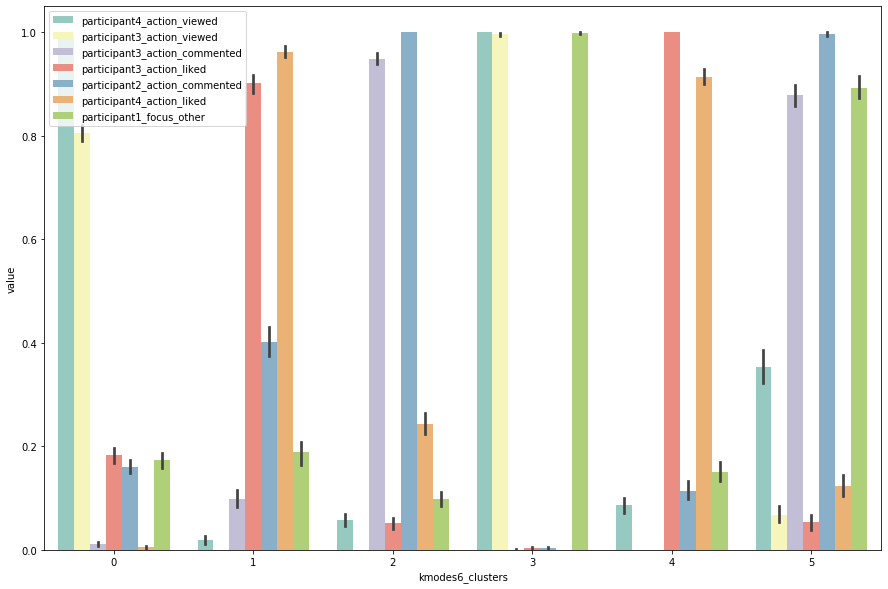

In [91]:
scaler = MinMaxScaler()
df = final_enc_df.drop(drop_columns, axis=1)
scaled_df = pd.DataFrame(scaler.fit_transform(df))
scaled_df.columns = df.columns
scaled_df['kmodes6_clusters'] = kmodes6_clusters

df_mean = scaled_df.groupby('kmodes6_clusters').mean().reset_index()

results = pd.DataFrame(columns=['var', 'std'])
for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]
selected_columns = list(results.sort_values('std', ascending=False).head(7)['var'].values) + ['kmodes6_clusters']

# Plot data.
tidy = scaled_df[selected_columns].melt(id_vars='kmodes6_clusters')
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x='kmodes6_clusters', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper left')
plt.savefig("kmodes_results/kmodes6_results.jpg", dpi=300)

#### K-Modes (k=7)

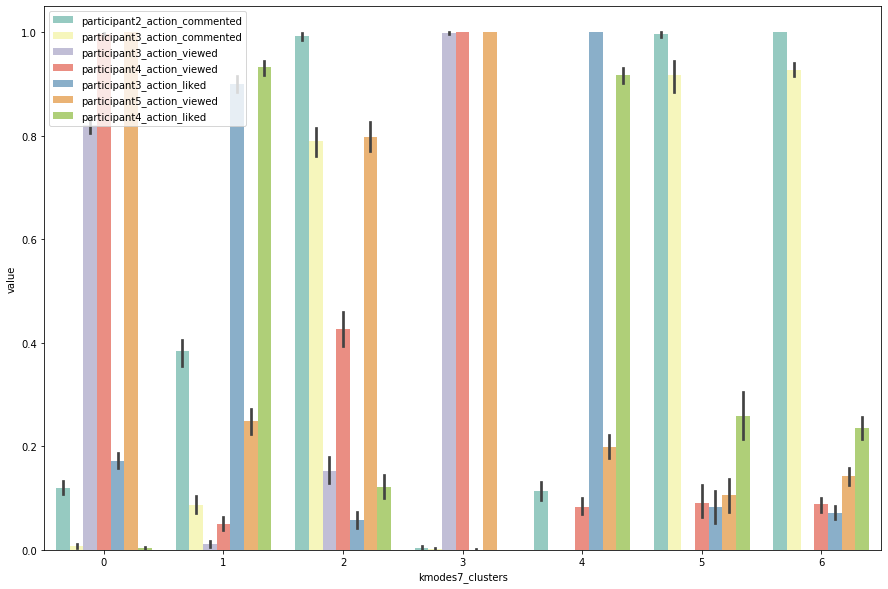

In [92]:
scaler = MinMaxScaler()
df = final_enc_df.drop(drop_columns, axis=1)
scaled_df = pd.DataFrame(scaler.fit_transform(df))
scaled_df.columns = df.columns
scaled_df['kmodes7_clusters'] = kmodes7_clusters

df_mean = scaled_df.groupby('kmodes7_clusters').mean().reset_index()

results = pd.DataFrame(columns=['var', 'std'])
for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]
selected_columns = list(results.sort_values('std', ascending=False).head(7)['var'].values) + ['kmodes7_clusters']

# Plot data.
tidy = scaled_df[selected_columns].melt(id_vars='kmodes7_clusters')
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x='kmodes7_clusters', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper left')
plt.savefig("kmodes_results/kmodes7_results.jpg", dpi=300)

#### K-Modes (k=8)

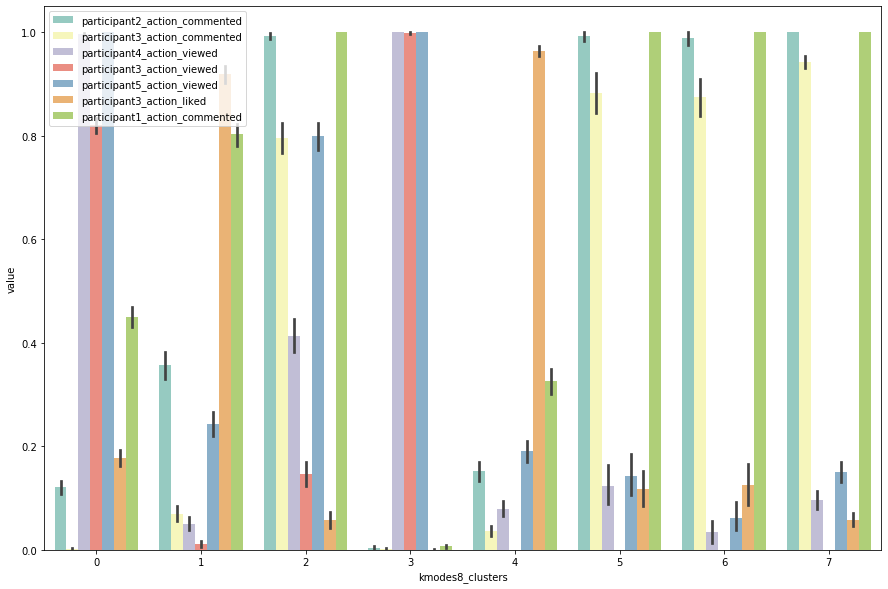

In [93]:
scaler = MinMaxScaler()
df = final_enc_df.drop(drop_columns, axis=1)
scaled_df = pd.DataFrame(scaler.fit_transform(df))
scaled_df.columns = df.columns
scaled_df['kmodes8_clusters'] = kmodes8_clusters

df_mean = scaled_df.groupby('kmodes8_clusters').mean().reset_index()

results = pd.DataFrame(columns=['var', 'std'])
for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]
selected_columns = list(results.sort_values('std', ascending=False).head(7)['var'].values) + ['kmodes8_clusters']

# Plot data.
tidy = scaled_df[selected_columns].melt(id_vars='kmodes8_clusters')
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x='kmodes8_clusters', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper left')
plt.savefig("kmodes_results/kmodes8_results.jpg", dpi=300)